In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scanpy as sc
import sklearn
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl
import scipy
import random
import scgpt as scg
from pathlib import Path

import sklearn


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# make GPU visible
os.environ["CUDA_VISIBLE_DEVICES"]="3"
torch.cuda.is_available()

True

In [2]:
import scipy.stats as stats

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean, se = np.mean(data), stats.sem(data)
    margin_of_error = se * stats.t.ppf((1 + confidence) / 2, n - 1)
    print("margin of error: {}".format(margin_of_error))
    return round(mean - margin_of_error,2), round(mean,2), round(mean + margin_of_error,2)

In [3]:
def accuracy_confidence_interval(accuracy, num_predictions, confidence=0.95):
    SE = np.sqrt((accuracy * (1 - accuracy)) / num_predictions)
    z = stats.norm.ppf((1 + confidence) / 2)
    margin_of_error = z * SE
    lower_bound = accuracy - margin_of_error
    upper_bound = accuracy + margin_of_error
    return (round(lower_bound, 2), round(accuracy,2), round(upper_bound,2))

# read data

In [2]:
h5ad_path = "/data/rna_rep_learning/hlca_sikkema2023/397410c1-bdc6-412d-888e-60cc401dd923.h5ad"
hlca_adata = sc.read_h5ad(h5ad_path)

In [4]:
hlca_adata

AnnData object with n_obs × n_vars = 2282447 × 56239
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 

In [6]:
hlca_adata.X.min()

0.0

In [17]:
hlca_adata.X.max()

8.863389

In [8]:
hlca_adata.raw.X.min()

0.0

In [9]:
hlca_adata.raw.X.max()

38487.0

In [10]:
hlca_adata.obsm['X_scanvi_emb'].shape

(2282447, 30)

## embed LuCA cells using scGPT

In [6]:
model_dir = Path("/data/rna_rep_learning/scGPT/scGPT_human")

In [7]:
# move raw counts to X for highly variable gene selection
hlca_adata.layers['counts'] = hlca_adata.raw.X.copy()
hlca_adata.layers['lognorm'] = hlca_adata.X.copy()
del hlca_adata.raw

In [8]:
# select highly variable genes
sc.pp.highly_variable_genes(hlca_adata, flavor='seurat')
hlca_adata_hvg = hlca_adata[:, hlca_adata.var['highly_variable']].copy()
np.sum(hlca_adata_hvg.X.sum(axis=1)==0) #want this to be 0

0

In [9]:
hlca_adata_hvg = scg.tasks.embed_data(
    hlca_adata_hvg,
    model_dir,
    gene_col="feature_name",
    batch_size=64,
    return_new_adata=False,
)

scGPT - INFO - match 3494/3779 genes in vocabulary of size 60697.


Embedding cells: 100%|█████████████████████████████████████████████████████████████████████████████| 35664/35664 [19:31<00:00, 30.44it/s]
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


In [10]:
#save this new adata
hlca_adata_hvg.write("/data/rna_rep_learning/hlca_sikkema2023/hlca_HVGonly_w_scGPT_embeds.h5ad")

In [4]:
hlca_adata_hvg = sc.read_h5ad("/data/rna_rep_learning/hlca_sikkema2023/hlca_HVGonly_w_scGPT_embeds.h5ad")

### Check that these scGPT embeddings look reasonable

In [12]:
sc.pp.neighbors(hlca_adata_hvg, use_rep="X_scGPT")

In [5]:
sc.tl.umap(hlca_adata_hvg)

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [9]:
#save this new adata
hlca_adata_hvg.write("/data/rna_rep_learning/hlca_sikkema2023/hlca_HVGonly_w_scGPT_embeds.h5ad")

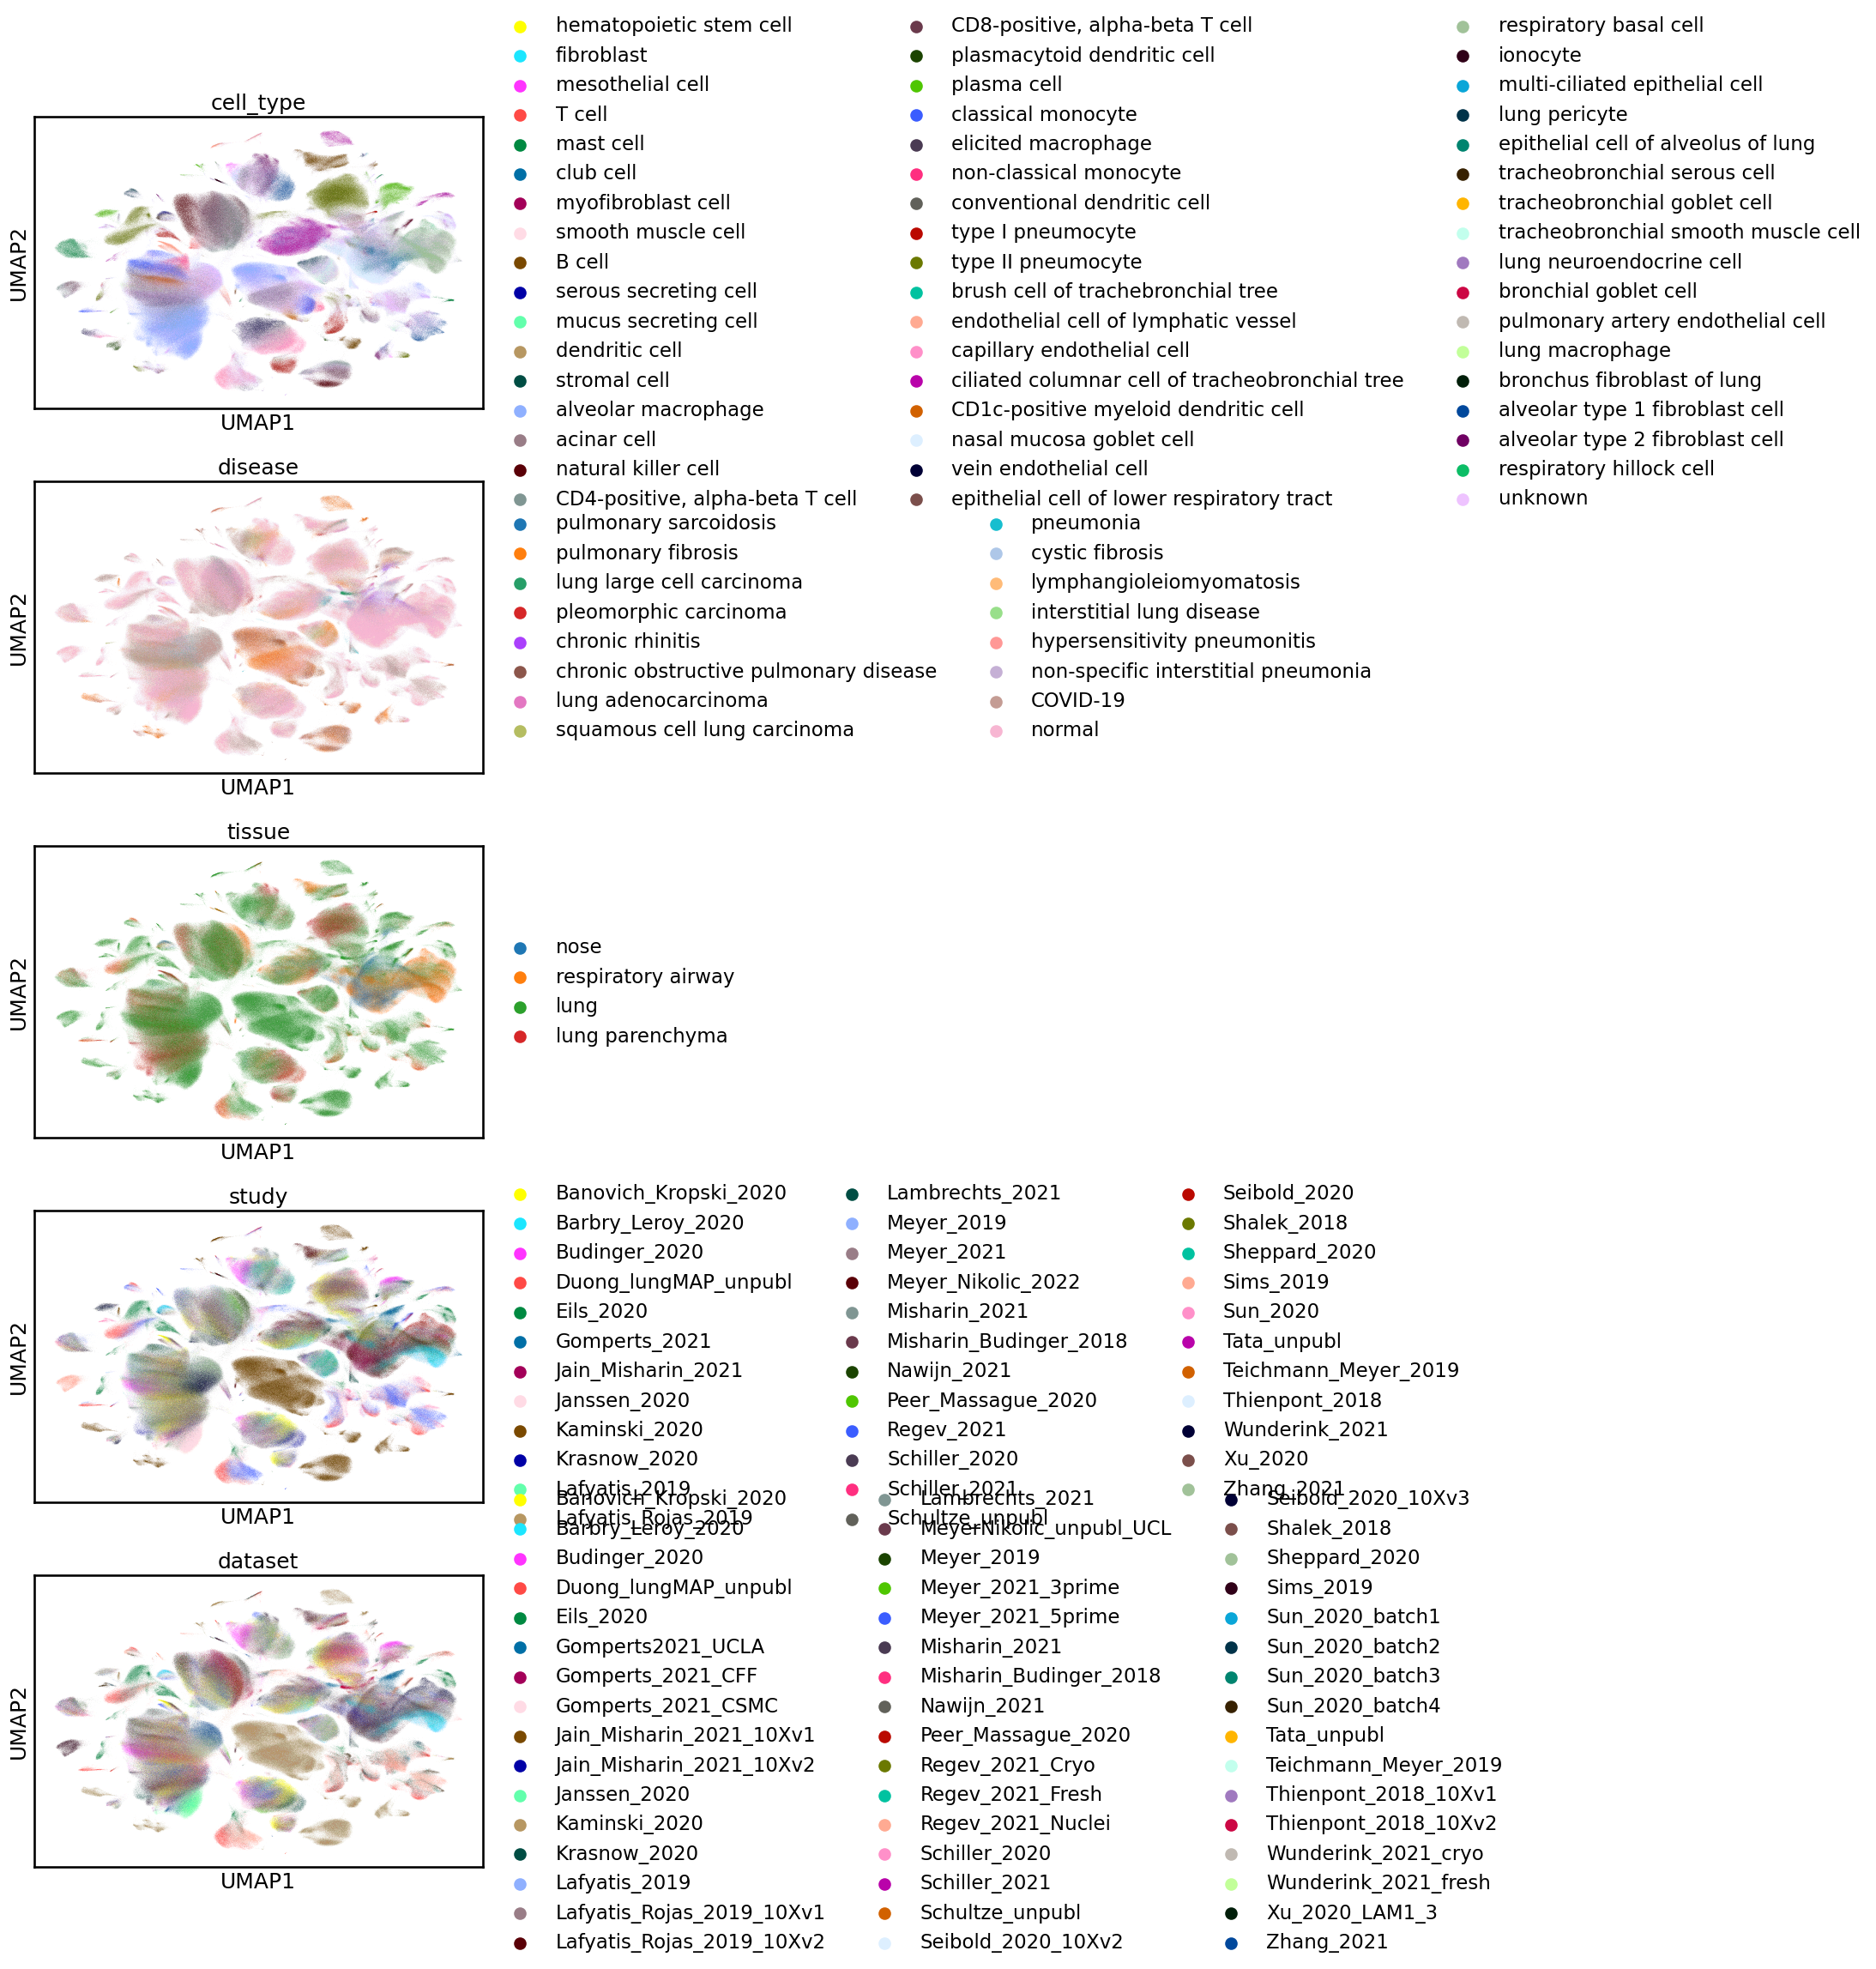

In [30]:
sc.pl.umap(hlca_adata_hvg, color=["cell_type","disease","tissue","study","dataset"],ncols=1)

In [10]:
hlca_adata_hvg

AnnData object with n_obs × n_vars = 2282447 × 3494
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', '

# explore metadata / how much data exists for each task

dictionary of variables can be found here: https://github.com/LungCellAtlas/HLCA/blob/main/docs/HLCA_metadata_explanation.csv

In [24]:
len(hlca_adata.obs['sample'].drop_duplicates())

731

In [25]:
hlca_adata.obs.loc[:,['tissue','sample']].drop_duplicates()['tissue'].value_counts()

tissue
lung                  498
respiratory airway     97
lung parenchyma        94
nose                   42
Name: count, dtype: int64

In [26]:
hlca_adata.obs.loc[hlca_adata.obs.tissue=="lung",['disease','sample']].drop_duplicates()['disease'].value_counts()

disease
normal                                   216
COVID-19                                  82
pulmonary fibrosis                        71
chronic obstructive pulmonary disease     24
cystic fibrosis                           22
lung adenocarcinoma                       20
interstitial lung disease                 16
squamous cell lung carcinoma              16
pneumonia                                 13
lung large cell carcinoma                  4
pleomorphic carcinoma                      4
non-specific interstitial pneumonia        3
hypersensitivity pneumonitis               3
pulmonary sarcoidosis                      2
lymphangioleiomyomatosis                   2
chronic rhinitis                           0
Name: count, dtype: int64

In [45]:
hlca_adata_hvg.obs.drop(columns=['suspension_type', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id',
       'organism_ontology_term_id', 'sex_ontology_term_id','fresh_or_frozen',
       'log10_total_counts','anatomical_region_ccf_score', "3'_or_5'",'observation_joinid','transf_ann_level_1_label','transf_ann_level_1_uncert',
       'transf_ann_level_2_label', 'transf_ann_level_2_uncert',
       'transf_ann_level_3_label', 'transf_ann_level_3_uncert',
       'transf_ann_level_4_label', 'transf_ann_level_4_uncert',
       'transf_ann_level_5_label', 'transf_ann_level_5_uncert','age_range', 'assay','organism','development_stage', 'total_counts', 'tissue_dissociation_protocol']).columns

Index(['donor_id', 'BMI', 'age_or_mean_of_age_range',
       'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1',
       'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5',
       'cause_of_death', 'core_or_extension', 'dataset', 'lung_condition',
       'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2',
       'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5',
       'original_ann_nonharmonized', 'reannotation_type', 'sample',
       'scanvi_label', 'sequencing_platform', 'smoking_status', 'study',
       'subject_type', 'tissue_coarse_unharmonized',
       'tissue_detailed_unharmonized', 'tissue_level_2', 'tissue_level_3',
       'tissue_sampling_method', 'tissue_type', 'cell_type', 'disease', 'sex',
       'tissue', 'self_reported_ethnicity'],
      dtype='object')

(array([42., 12., 18., 56., 44., 29., 57., 84., 36., 26.]),
 array([ 0. ,  8.1, 16.2, 24.3, 32.4, 40.5, 48.6, 56.7, 64.8, 72.9, 81. ]),
 <BarContainer object of 10 artists>)

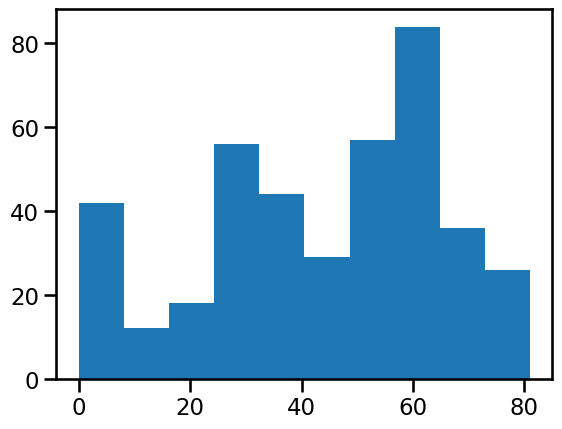

In [50]:
plt.hist(hlca_adata_hvg.obs[["sample","age_or_mean_of_age_range"]].drop_duplicates()["age_or_mean_of_age_range"])

In [51]:
hlca_adata_hvg.obs[["sample","smoking_status"]].drop_duplicates()["smoking_status"].value_counts()

smoking_status
never                    165
active                    84
former                    31
hist of marijuana use      9
Name: count, dtype: int64

# create pseudobulk embeddings to use downstream

In [3]:
adata = hlca_adata_hvg
sample_col = 'sample'

In [4]:
pbulk_embs = {}

#### scGPT

In [5]:
emb_name = 'X_scGPT'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4027818/2538767356.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### scGPT -> 40 PCs

In [6]:
emb_name = 'X_scGPT'

pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

## Input
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs['scgpt_40PCs'] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4027818/2718990846.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### scANVI

In [7]:
emb_name = 'X_scanvi_emb'

## Input
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()

#limit to the sample pool, this will also put it in the right order to index using the groupkfold inds
pbulk_embs[emb_name] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4027818/1297532230.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.loc[:,sample_col]).reset_index().groupby(sample_col).mean()


#### cell type props

In [8]:
## Input
celltype_counts_df = pd.DataFrame(adata.obs.groupby('sample').cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index="sample", columns="cell_type", values="cell_type_counts")
celltype_fracs_df = celltype_counts_df.div(celltype_counts_df.sum(axis=1), axis=0)
pseudobulk_input = celltype_fracs_df
pbulk_embs['ct_props'] = pseudobulk_input#.loc[sample_pool,:]

/tmp/ipykernel_4027818/1678127110.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_counts_df = pd.DataFrame(adata.obs.groupby('sample').cell_type.value_counts()).rename({'count':'cell_type_counts'},axis=1).reset_index().pivot(index="sample", columns="cell_type", values="cell_type_counts")


#### cell type props + mean embedding based on scGPT

In [9]:
#get mean embedding per cell type

emb_name = 'X_scGPT'

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_4027818/3601337964.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(adata.obsm[emb_name], index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [10]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPTfull'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

#### cell type props + mean embedding based on scGPT+40PCs

In [11]:
#get mean embedding per cell type

emb_name = 'X_scGPT'
pca = sklearn.decomposition.PCA(n_components=40)
scgpt_input_pca = pca.fit_transform(adata.obsm[emb_name])

# get mean embedding per sample+cell_type
pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()

# change columns to more interpretable strs 
pseudobulk_input.columns = ['scgpt_'+str(c) for c in pseudobulk_input.columns]

# cell types that dont exist in a given sample - fill 0 for mean expression
pseudobulk_input = pseudobulk_input.fillna(0).reset_index()

# Pivot the dataframe
psblk_per_celltype = pseudobulk_input.pivot(index=sample_col, columns='cell_type')

# Flatten the multi-level columns
psblk_per_celltype.columns = ['_'.join(col).strip() for col in psblk_per_celltype.columns.values]

/tmp/ipykernel_4027818/125621020.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk_input = pd.DataFrame(scgpt_input_pca, index=adata.obs.index).merge(adata.obs[[sample_col,'cell_type']], right_index=True, left_index=True).groupby([sample_col,'cell_type']).mean()


In [12]:
# concat cell type fracs and mean embs dfs
pbulk_embs['ct_fracs_means_scGPT_40PCs'] = pbulk_embs['ct_props'].merge(psblk_per_celltype, right_index=True, left_index=True)

# task 1: classify normal vs. covid vs. pulm fibrosis


## define sample pool, target, X, splits for this task

### define sample_pool for this target

In [5]:
adata = hlca_adata_hvg

In [6]:
sample_col = 'sample'
target_col = 'disease'

#get sample IDs that are not NA for this target
notNA_samples = adata.obs[[sample_col,target_col]].drop_duplicates()[sample_col][~adata.obs[[sample_col,target_col]].drop_duplicates()[target_col].isna()]
print("this target has {} non-NA samples".format(len(notNA_samples)))


this target has 731 non-NA samples


In [7]:
# limit to lung, {normal, covid, PF}
lung_samples = adata.obs.loc[adata.obs.tissue=="lung",sample_col].drop_duplicates()
disease_samples = adata.obs.loc[adata.obs.disease.isin(['normal','COVID-19','pulmonary fibrosis']),sample_col].drop_duplicates()

In [8]:
sample_pool = np.intersect1d(np.intersect1d(disease_samples, notNA_samples), lung_samples)

In [9]:
counts_total_sample_pool = adata.obs.set_index(sample_col).loc[sample_pool].reset_index()[["disease",sample_col]].drop_duplicates().disease.astype("string").value_counts()
print(counts_total_sample_pool)

disease
normal                216
COVID-19               82
pulmonary fibrosis     71
Name: count, dtype: Int64


In [10]:
# sample a balanced pool of samples
sample_pool = adata.obs.loc[(adata.obs[sample_col].isin(sample_pool)),[sample_col, target_col]].astype("string").drop_duplicates().groupby(target_col).sample(n=np.min(counts_total_sample_pool))["sample"]

In [11]:
print(len(sample_pool))

213


#### save an anndata object that only contains sample_pool to pass into scSet

In [12]:
hlca_adata_hvg[hlca_adata_hvg.obs[sample_col].isin(sample_pool),:].write("/data/rna_rep_learning/hlca_sikkema2023/hlca_HVGonly_w_scGPT_embeds_SAMPLEPOOL_for_covidPFnormal_n213.h5ad")

### define target, and limit/order by sample_pool

In [41]:
## Define targets
targets = adata.obs.loc[:, [sample_col, target_col]].drop_duplicates().set_index(sample_col).loc[sample_pool,target_col]
labels, targets_ind = np.unique(targets, return_inverse=True)
targets = pd.Series(targets_ind, index=targets.index)

In [42]:
labels

array(['COVID-19', 'normal', 'pulmonary fibrosis'], dtype=object)

In [43]:
targets.value_counts()/len(targets)

0    0.333333
1    0.333333
2    0.333333
Name: count, dtype: float64

### splits for leave one (dataset) out cross validation

In [44]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=10)
groups = adata.obs.set_index(sample_col).loc[sample_pool, 'dataset'].reset_index().drop_duplicates().dataset
splits = list(group_kfold.split(sample_pool, groups=groups)) #if don't convert to list, iterator is exhausted after one use


In [45]:
for (train_index, test_index) in splits:
    print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))
    print("n samples in train: ", len(train_index))
    print("n samples in test: ", len(test_index))
    print("\n")

/tmp/ipykernel_4027818/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Kaminski_2020']
n samples in train:  157
n samples in test:  56




/tmp/ipykernel_4027818/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Lambrechts_2021']
n samples in train:  193
n samples in test:  20




/tmp/ipykernel_4027818/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Regev_2021_Nuclei', 'Peer_Massague_2020', 'Tata_unpubl']
n samples in train:  195
n samples in test:  18




/tmp/ipykernel_4027818/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Sims_2019', 'Schiller_2021', 'Banovich_Kropski_2020']
n samples in train:  196
n samples in test:  17




/tmp/ipykernel_4027818/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Budinger_2020', 'Gomperts2021_UCLA', 'Sun_2020_batch4']
n samples in train:  196
n samples in test:  17




/tmp/ipykernel_4027818/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Regev_2021_Fresh', 'Meyer_2021_5prime', 'Sun_2020_batch2']
n samples in train:  196
n samples in test:  17




/tmp/ipykernel_4027818/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Zhang_2021', 'Regev_2021_Cryo', 'Sheppard_2020']
n samples in train:  196
n samples in test:  17




/tmp/ipykernel_4027818/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Wunderink_2021_cryo', 'Gomperts_2021_CSMC', 'Sun_2020_batch3', 'Misharin_Budinger_2018']
n samples in train:  196
n samples in test:  17




/tmp/ipykernel_4027818/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


datasets reserved for test fold:  ['Wunderink_2021_fresh', 'Eils_2020', 'Janssen_2020', 'Schiller_2020']
n samples in train:  196
n samples in test:  17


datasets reserved for test fold:  ['Schultze_unpubl', 'MeyerNikolic_unpubl_UCL', 'Meyer_2021_3prime', 'Gomperts_2021_CFF']
n samples in train:  196
n samples in test:  17




/tmp/ipykernel_4027818/1982975917.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("datasets reserved for test fold: ", list(adata.obs.set_index(sample_col).loc[sample_pool[test_index]].dataset.drop_duplicates()))


### limit/order pseudobulk embeddings by sample_pool

In [46]:
this_pbulk_embs = {}
for emb in pbulk_embs:
    this_pbulk_embs[emb] = pbulk_embs[emb].loc[sample_pool]

## calculate heuristic baseline performance on these splits

not including majority class per study as a baseline, since we shouldn't have study based batch effects affecting performance using our GroupKFold!

In [47]:
val_majclass_bline_accs= []

for (train_index, val_index) in splits:
    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))

print("baseline accuracy on K val sets: ", val_majclass_bline_accs)
print("mean accuracy: ", np.mean(val_majclass_bline_accs))

baseline accuracy on K val sets:  [0, 0, 0, 0, 0, 0, 0.23529411764705882, 0.29411764705882354, 0.23529411764705882, 0]
mean accuracy:  0.07647058823529411


## Evaluate models using nested GroupKFold CV

In [48]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def nested_kfold_eval(pseudobulk_input, targets, splits, model, param_grid):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(model, param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=group_kfold, groups=groups)
    
    print("Nested CV Score: ", nested_score.mean())
    
    return nested_score

In [49]:
# set up a dict with models and hparams to test

model_param_dict = {
    'KNN': (KNeighborsClassifier(), {'n_neighbors':np.arange(10)+1}),
    'random_forest' : (RandomForestClassifier(), {'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]})
}


In [50]:
ds_results = {}
for model in model_param_dict:
    print("--------- {} ----------".format(model))
    ds_results[model] = {}
    for emb in this_pbulk_embs:
        print('embedding: ', emb)
        print('shape of embedding: ', this_pbulk_embs[emb].shape)
        ds_results[model][emb] = nested_kfold_eval(this_pbulk_embs[emb], targets, splits, model=model_param_dict[model][0], param_grid = model_param_dict[model][1])
        print("\n")
    print("\n")

--------- KNN ----------
embedding:  X_scGPT
shape of embedding:  (213, 512)
Nested CV Score:  0.43457749766573295


embedding:  scgpt_40PCs
shape of embedding:  (213, 40)
Nested CV Score:  0.42369514472455644


embedding:  X_scanvi_emb
shape of embedding:  (213, 30)
Nested CV Score:  0.4177917833800186


embedding:  ct_props
shape of embedding:  (213, 51)
Nested CV Score:  0.47148225957049483


embedding:  ct_fracs_means_scGPTfull
shape of embedding:  (213, 26163)
Nested CV Score:  0.5865943043884221


embedding:  ct_fracs_means_scGPT_40PCs
shape of embedding:  (213, 2091)
Nested CV Score:  0.593109243697479




--------- random_forest ----------
embedding:  X_scGPT
shape of embedding:  (213, 512)
Nested CV Score:  0.4389892623716153


embedding:  scgpt_40PCs
shape of embedding:  (213, 40)
Nested CV Score:  0.42510270774976655


embedding:  X_scanvi_emb
shape of embedding:  (213, 30)
Nested CV Score:  0.41673902894491127


embedding:  ct_props
shape of embedding:  (213, 51)
Nested CV 

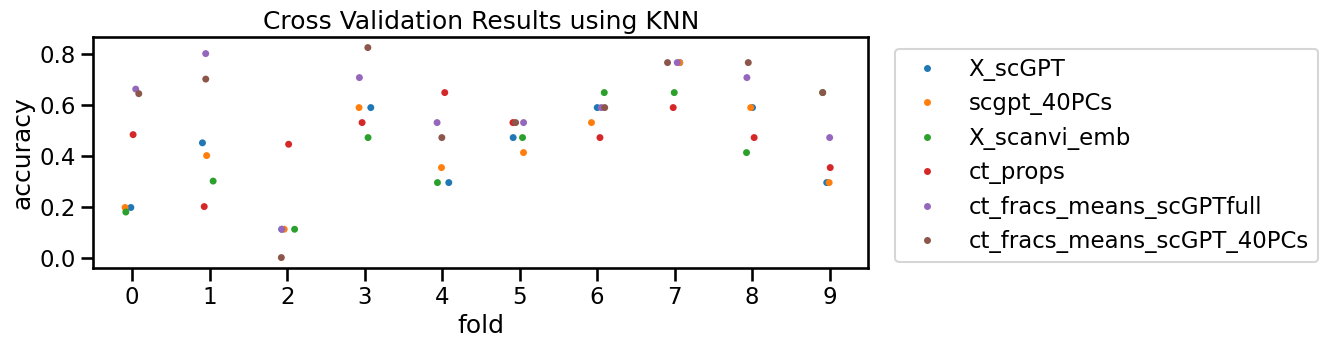

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(ds_results['KNN']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using KNN")

# Show the plot
plt.show()

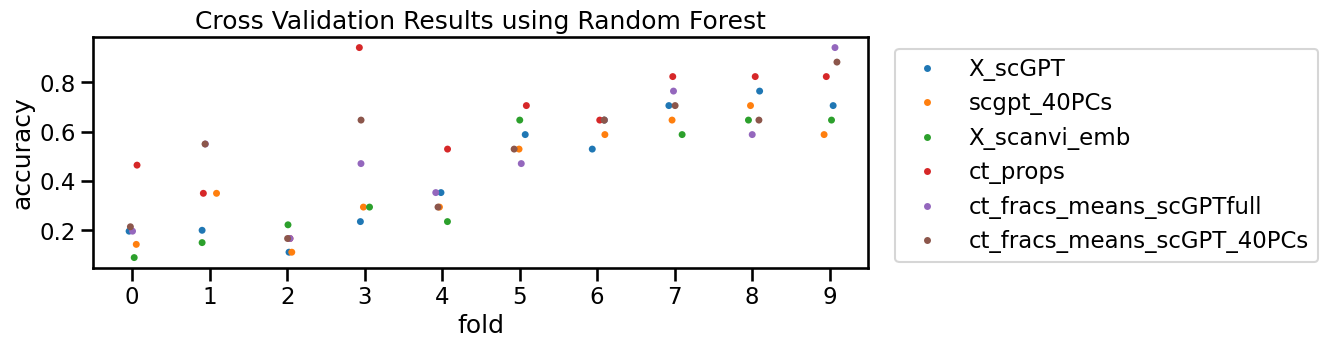

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjust the figure size
plt.figure(figsize=(10, 3))  # Width = 12, Height = 6 (you can change these values as needed)

# Create the stripplot
sns.stripplot(
    data=pd.DataFrame(ds_results['random_forest']).reset_index().rename(columns={"index": "fold"}).melt(id_vars="fold"),
    x="fold",
    y="value",
    hue="variable"
)

# Move the legend to the right side outside the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.ylabel("accuracy")
plt.title("Cross Validation Results using Random Forest")

# Show the plot
plt.show()

## TO DO - significance testing, not most important for getting high level sense of where the signal is

In [ ]:
# check significance of promising results

# need to record per-sample predictions and then FOR SAMPLES where models disagree, can run either binomial or wilcoxon signed-rank test


In [140]:
## train KNN w/ Kfold CV
from sklearn.model_selection import GridSearchCV, cross_val_score

def train_lr(pseudobulk_input, targets, splits, param_grid = {'C': [1e-10,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,1e2,1e3,1e4,1e5,1e10]}):

    # Inner CV for hyperparameter tuning
    inner_cv = GridSearchCV(LogisticRegression(penalty='l2', solver='sag', max_iter=1000), param_grid, cv=5)

    # Nested CV
    nested_score = cross_val_score(inner_cv, pseudobulk_input, targets, cv=group_kfold, groups=groups)
    
    print("Nested CV Score: ", nested_score.mean())
    
    return nested_score

In [141]:
lr_results = {}
for emb in pbulk_embs:
    print(emb)
    print(pbulk_embs[emb].shape)
    lr_results[emb] = train_lr(pbulk_embs[emb], targets, splits)
    print("\n")

scgpt_40PCs
(369, 40)


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/rpeyser/e

KeyboardInterrupt: 

# BELOW HERE is logistic regression for disease stage prediction -- DID NOT CONVERGE -- can see the permutations I tried

#### old code logistic regression

In [ ]:
val_accs = []
val_aucs = []
Cs = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]
for c in Cs:
    neigh = LogisticRegression(C=c)
    neigh.fit(train_dataset[:][0], train_dataset[:][1])
    preds = neigh.predict(val_dataset[:][0])
    val_acc = accuracy_score(val_dataset[:][1], preds)
    val_accs.append(val_acc)
    val_aucs.append(roc_auc_score(val_dataset[:][1], neigh.predict_proba(val_dataset[:][0])[:,1]))
plt.plot(Cs, val_accs)
plt.xscale("log")

In [377]:
bestc = Cs[np.argmax(val_accs)]
print("best C = ", bestc)
print("val acc: ", val_accs[np.argmax(val_accs)])
print("val AUC ", val_aucs[np.argmax(val_accs)])
neigh = LogisticRegression(C=c)
neigh.fit(train_dataset[:][0], train_dataset[:][1])
preds = neigh.predict(test_dataset[:][0])
print("test acc: ", accuracy_score(test_dataset[:][1], preds))
print("test AUC ", roc_auc_score(test_dataset[:][1], neigh.predict_proba(test_dataset[:][0])[:,1]))

best C =  100
val acc:  0.8421052631578947
val AUC  0.8185595567867037
test acc:  0.7543859649122807
test AUC  0.7506925207756232


/opt/conda/rpeyser/envs/scgpt_2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
## train LR w/ Kfold CV
def train_lr(pseudobulk_input, targets, splits, 
             Cs = [1e-100,1e-50,1e-40,1e-30,1e-20,1e-10,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,1e2,1e3,1e4,1e5,1e10,1e20,1e30,1e50,1e100],
            debug=False):
    
    val_accs = []
    test_accs= []
    train_accs = []
    val_aucs = []
    chosen_cs=[]
    val_majclass_bline_accs = []
    test_majclass_bline_accs = []
    #k=9
    split_index = 0
    for (train_index, test_index) in splits:
        split_index+=1
        val_accs_hparam_search = []
    
        #split test set into val and test halves
        val_index = test_index[:int(len(test_index)/2)]
        test_index = test_index[int(len(test_index)/2):]
    
        #calculate baseline performance - majority class
        majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
        if debug:
            print("train set value counts: ")
            print(np.round(targets.iloc[train_index].value_counts()/len(train_index)*100,2))
        if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
            val_majclass_bline_accs.append(0)
        else:
            val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))
        if majclass_bline_pred not in targets.iloc[test_index].value_counts().index:
            test_majclass_bline_accs.append(0)
        else:
            test_majclass_bline_accs.append(targets.iloc[test_index].value_counts()[majclass_bline_pred]/len(test_index))
    
        #tune hyperparam on this split's val set
        for c in Cs:
            neigh = LogisticRegression(C=c, penalty='l1', solver='liblinear')
            neigh.fit(pseudobulk_input.iloc[train_index,:], targets.iloc[train_index])
            preds = neigh.predict(pseudobulk_input.iloc[val_index,:])
            val_acc = accuracy_score(targets.iloc[val_index], preds)
            val_accs_hparam_search.append(val_acc)
        if debug:
            plt.xscale("log")
            plt.plot(Cs, val_accs_hparam_search)
            plt.title("val acc across hparams for split {}".format(split_index))
            plt.show()
        
        bestc = Cs[np.argmax(val_accs_hparam_search)]
        chosen_cs.append(bestc)
    
        neigh = LogisticRegression(C=bestc, penalty='l1', solver='liblinear', max_iter=300)
        neigh.fit(pseudobulk_input.iloc[train_index,:], targets.iloc[train_index])
        
        #print train score
        preds = neigh.predict(pseudobulk_input.iloc[train_index,:])
        train_acc = accuracy_score(targets.iloc[train_index], preds)
        train_accs.append(train_acc)        
        
        #final val score
        preds = neigh.predict(pseudobulk_input.iloc[val_index,:])
        val_acc = accuracy_score(targets.iloc[val_index], preds)
        val_accs.append(val_acc)
    
        #final test score
        preds = neigh.predict(pseudobulk_input.iloc[test_index,:])
        test_acc = accuracy_score(targets.iloc[test_index], preds)
        test_accs.append(test_acc)
        print("\n")

    #print summary stats across folds
    print("-- summary across {} folds --".format(len(splits)))
    print("chosen c's: ", chosen_cs)
    print("mean val acc across folds: {}; range: {} - {}".format(np.round(np.mean(val_accs),3), np.round(np.min(val_accs),3), np.round(np.max(val_accs),3)))
    print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
    try:
        print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))
    except:
        print("can't calculate wilcoxon for val set - baseline and model predicted accuracies the same across folds")
    print("mean test acc across folds: {}; range: {} - {}".format(np.round(np.mean(test_accs),3), np.round(np.min(test_accs),3), np.round(np.max(test_accs),3)))
    print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
    try:
        print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))
    except:
        print("can't calculate wilcoxon for test set - baseline and model predicted accuracies the same across folds")

    return val_accs, test_accs, train_accs, chosen_cs, val_majclass_bline_accs, test_majclass_bline_accs

In [96]:
#train_KNN()
for emb in pbulk_embs:
    print(emb)
    print(pbulk_embs[emb].shape)
    train_lr(pbulk_embs[emb], targets, splits)
    print("\n")
    

scgpt_40PCs
(369, 40)




/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(




-- summary across 5 folds --
chosen c's:  [100000.0, 1, 1e-100, 1e-100, 0.1]
mean val acc across folds: 0.687; range: 0.556 - 0.917
mean majority class baseline val acc across folds:  0.55
wilcoxon signed-rank test p-value=0.068
mean test acc across folds: 0.468; range: 0.167 - 0.972
mean majority class baseline test acc across folds:  0.628
wilcoxon signed-rank test p-value=0.273


X_scanvi_emb
(369, 30)


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/con

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit



-- summary across 5 folds --
chosen c's:  [1e+100, 0.1, 1e-100, 1e-100, 0.1]
mean val acc across folds: 0.659; range: 0.556 - 0.756
mean majority class baseline val acc across folds:  0.55
wilcoxon signed-rank test p-value=0.438
mean test acc across folds: 0.452; range: 0.167 - 0.762
mean majority class baseline test acc across folds:  0.628
wilcoxon signed-rank test p-value=0.312


ct_props
(369, 51)


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/sit



-- summary across 5 folds --
chosen c's:  [1000.0, 10, 1e-100, 1e-100, 0.1]
mean val acc across folds: 0.701; range: 0.556 - 0.917
mean majority class baseline val acc across folds:  0.55
wilcoxon signed-rank test p-value=0.068
mean test acc across folds: 0.462; range: 0.167 - 0.917
mean majority class baseline test acc across folds:  0.628
wilcoxon signed-rank test p-value=0.273


ct_fracs_means
(369, 26163)










-- summary across 5 folds --
chosen c's:  [1000.0, 0.1, 10, 1e-100, 0.1]
mean val acc across folds: 0.736; range: 0.556 - 0.889
mean majority class baseline val acc across folds:  0.55
wilcoxon signed-rank test p-value=0.109
mean test acc across folds: 0.644; range: 0.167 - 0.861
mean majority class baseline test acc across folds:  0.628
wilcoxon signed-rank test p-value=0.593




/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


In [112]:
for (train_index, test_index) in splits:
    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]
    
    print("val set value counts: ")
    print(np.round(targets.iloc[val_index].value_counts()/len(val_index)*100,2))

val_accs

val set value counts: 
2    58.54
1    41.46
Name: count, dtype: float64
val set value counts: 
1    88.89
0    11.11
Name: count, dtype: float64
val set value counts: 
0    62.86
1    37.14
Name: count, dtype: float64
val set value counts: 
0    55.56
1    30.56
2    13.89
Name: count, dtype: float64
val set value counts: 
1    77.14
2    14.29
0     8.57
Name: count, dtype: float64


[0.4146341463414634,
 0.8888888888888888,
 0.6285714285714286,
 0.5555555555555556,
 0.7714285714285715]

In [111]:
test_accs

[0.5,
 0.7777777777777778,
 0.19444444444444445,
 0.16666666666666666,
 0.5555555555555556]

In [87]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))

mean val acc across folds:  0.652
mean majority class baseline val acc across folds:  0.55
wilcoxon signed-rank test p-value=0.18


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


#### for groupkfold splits with PCA applied to scGPT embeddings (40 PCs)

In [132]:
## train LR w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Cs = [1e-100,1e-50,1e-40,1e-30,1e-20,1e-10,1e-5,1e4,1e-3,1e-2,1e-2,1,10,1e2,1e3,1e4,1e5,1e10]
chosen_cs=[]
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]

    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    print("train set value counts: ")
    print(np.round(targets.iloc[train_index].value_counts()/len(train_index)*100,2))
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    if majclass_bline_pred not in targets.iloc[test_index].value_counts().index:
        test_majclass_bline_accs.append(0)
    else:
        test_majclass_bline_accs.append(targets.iloc[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    #tune hyperparam on this split's val set
    for c in Cs:
        neigh = LogisticRegression(C=c, penalty='l1', solver='liblinear')
        neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])
        preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
        val_acc = accuracy_score(targets.iloc[val_index], preds)
        val_accs_hparam_search.append(val_acc)
    print(val_accs_hparam_search)
    bestc = Cs[np.argmax(val_accs_hparam_search)]
    chosen_cs.append(bestc)

    neigh = LogisticRegression(C=bestc, penalty='l1', solver='liblinear')
    neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])
    
    #print train score
    preds = neigh.predict(pseudobulk_input.iloc[train_index,:].dropna())
    train_acc = accuracy_score(targets.iloc[train_index], preds)
    print("train acc: ", train_acc)
    
    #final val score
    preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
    val_acc = accuracy_score(targets.iloc[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    preds = neigh.predict(pseudobulk_input.iloc[test_index,:].dropna())
    test_acc = accuracy_score(targets.iloc[test_index], preds)
    test_accs.append(test_acc)
    print("\n")

train set value counts: 
1    62.24
0    28.67
2     9.09
Name: count, dtype: float64
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3902439024390244, 0.0, 0.0, 0.0, 0.4146341463414634, 0.4146341463414634, 0.4146341463414634, 0.4146341463414634, 0.4146341463414634, 0.5853658536585366, 0.6097560975609756]
train acc:  1.0


train set value counts: 
1    52.53
2    23.91
0    23.57
Name: count, dtype: float64


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.6111111111111112, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.9166666666666666, 0.5277777777777778, 0.4722222222222222, 0.5277777777777778, 0.6111111111111112, 0.6111111111111112, 0.6111111111111112]
train acc:  0.632996632996633


train set value counts: 
1    58.39
2    23.83
0    17.79
Name: count, dtype: float64


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[0.6285714285714286, 0.6285714285714286, 0.6285714285714286, 0.6285714285714286, 0.6285714285714286, 0.6285714285714286, 0.6285714285714286, 0.2571428571428571, 0.6285714285714286, 0.6285714285714286, 0.6285714285714286, 0.37142857142857144, 0.2857142857142857, 0.11428571428571428, 0.22857142857142856, 0.2571428571428571, 0.3142857142857143, 0.3142857142857143]
train acc:  0.17785234899328858


train set value counts: 
1    62.96
0    18.86
2    18.18
Name: count, dtype: float64
[0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.4444444444444444, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.3333333333333333, 0.3888888888888889, 0.3888888888888889, 0.4166666666666667, 0.4444444444444444, 0.4444444444444444, 0.4722222222222222]
train acc:  0.18855218855218855


train set value counts: 
1    56.71
0    22.48
2    20.81
Name: count, dtype: float64
[0.08571428571428572, 0.08571428571

/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [133]:
chosen_cs

[10000000000.0, 1, 1e-100, 1e-100, 1]

In [134]:
for (train_index, test_index) in splits:
    #split test set into val and test halves
    val_index = test_index[:int(len(test_index)/2)]
    test_index = test_index[int(len(test_index)/2):]
    
    print("val set value counts: ")
    print(np.round(targets.iloc[val_index].value_counts()/len(val_index)*100,2))

val_accs

val set value counts: 
2    58.54
1    41.46
Name: count, dtype: float64
val set value counts: 
1    88.89
0    11.11
Name: count, dtype: float64
val set value counts: 
0    62.86
1    37.14
Name: count, dtype: float64
val set value counts: 
0    55.56
1    30.56
2    13.89
Name: count, dtype: float64
val set value counts: 
1    77.14
2    14.29
0     8.57
Name: count, dtype: float64


[0.6097560975609756,
 0.9166666666666666,
 0.6285714285714286,
 0.5555555555555556,
 0.6857142857142857]

In [135]:
test_accs

[0.47619047619047616,
 0.9722222222222222,
 0.19444444444444445,
 0.16666666666666666,
 0.6111111111111112]

In [136]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))

mean val acc across folds:  0.679
mean majority class baseline val acc across folds:  0.55
wilcoxon signed-rank test p-value=0.188


In [137]:
print("mean test acc across folds: ", np.round(np.mean(test_accs),3))
print("mean majority class baseline test acc across folds: ", np.round(np.mean(test_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(test_accs, test_majclass_bline_accs)[1],3)))

mean test acc across folds:  0.484
mean majority class baseline test acc across folds:  0.628
wilcoxon signed-rank test p-value=0.625


#### are val and test sets too small? try only having val (but note this might lead to inflated results since hyperparams are chosen on val set)

In [121]:
## train LR w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Cs = [1e-100,1e-50,1e-40,1e-30,1e-20,1e-10,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,1e4,1e5,1e10]
chosen_cs=[]
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, val_index) in splits:


    val_accs_hparam_search = []

    #split test set into val and test halves
    #val_index = test_index[:int(len(test_index)/2)]
    #test_index = test_index[int(len(test_index)/2):]

    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    #if majclass_bline_pred not in targets.iloc[test_index].value_counts().index:
    #    test_majclass_bline_accs.append(0)
    #else:
    #   test_majclass_bline_accs.append(targets.iloc[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    #tune hyperparam on this split's val set
    for c in Cs:
        neigh = LogisticRegression(C=c, penalty='l1', solver='liblinear')
        neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])
        preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
        val_acc = accuracy_score(targets.iloc[val_index], preds)
        val_accs_hparam_search.append(val_acc)
    print(val_accs_hparam_search)
    bestc = Cs[np.argmax(val_accs_hparam_search)]
    chosen_cs.append(bestc)

    neigh = LogisticRegression(C=bestc, penalty='l1', solver='liblinear')
    neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])

    #final val score
    preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
    val_acc = accuracy_score(targets.iloc[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    #preds = neigh.predict(pseudobulk_input.iloc[test_index,:].dropna())
    #test_acc = accuracy_score(targets.iloc[test_index], preds)
    #test_accs.append(test_acc)
    

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4578313253012048, 0.4578313253012048, 0.43373493975903615, 0.4578313253012048, 0.4578313253012048, 0.4578313253012048, 0.4457831325301205, 0.4578313253012048]
[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.8333333333333334, 0.8333333333333334, 0.8194444444444444, 0.7916666666666666, 0.8333333333333334, 0.8055555555555556, 0.7916666666666666, 0.7222222222222222]
[0.4084507042253521, 0.4084507042253521, 0.4084507042253521, 0.4084507042253521, 0.4084507042253521, 0.4084507042253521, 0.4084507042253521, 0.4084507042253521, 0.4084507042253521, 0.4084507042253521, 0.5915492957746479, 0.5915492957746479, 0.6197183098591549, 0.5211267605633803, 0.647887323943662, 0.5915492957746479, 0.5915492957746479, 0.5352112676056338]
[0.3611111111111111, 0.3611111111111111, 0.36111111111111

In [122]:
chosen_cs

[0.1, 0.1, 1000, 10, 0.1]

In [123]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))

mean val acc across folds:  0.623
mean majority class baseline val acc across folds:  0.589
wilcoxon signed-rank test p-value=0.18


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


In [82]:
## train LR w/ Kfold CV
val_accs = []
test_accs= []
val_aucs = []
Cs = [1e-100,1e-50,1e-40,1e-30,1e-20,1e-10,1,1e5,1e10]
chosen_cs=[]
val_majclass_bline_accs = []
test_majclass_bline_accs = []
#k=9
for (train_index, test_index) in splits:

    val_accs_hparam_search = []

    #split test set into val and test halves
    #val_index = test_index[:int(len(test_index)/2)]
    #test_index = test_index[int(len(test_index)/2):]

    #calculate baseline performance - majority class
    majclass_bline_pred = targets.iloc[train_index].value_counts().index[targets.iloc[train_index].value_counts().argmax()]
    if majclass_bline_pred not in targets.iloc[val_index].value_counts().index:
        val_majclass_bline_accs.append(0)
    else:
        val_majclass_bline_accs.append(targets.iloc[val_index].value_counts()[majclass_bline_pred]/len(val_index))
    #if majclass_bline_pred not in targets.iloc[test_index].value_counts().index:
    #    test_majclass_bline_accs.append(0)
    #else:
    #   test_majclass_bline_accs.append(targets.iloc[test_index].value_counts()[majclass_bline_pred]/len(test_index))

    #tune hyperparam on this split's val set
    for c in Cs:
        neigh = LogisticRegression(C=c, penalty='l1', solver='liblinear')
        neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])
        preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
        val_acc = accuracy_score(targets.iloc[val_index], preds)
        val_accs_hparam_search.append(val_acc)
    print(val_accs_hparam_search)
    bestc = Cs[np.argmax(val_accs_hparam_search)]
    chosen_cs.append(bestc)

    neigh = LogisticRegression(C=bestc, penalty='l1', solver='liblinear')
    neigh.fit(pseudobulk_input.iloc[train_index,:].dropna(), targets.iloc[train_index])

    #final val score
    preds = neigh.predict(pseudobulk_input.iloc[val_index,:].dropna())
    val_acc = accuracy_score(targets.iloc[val_index], preds)
    val_accs.append(val_acc)

    #final test score
    #preds = neigh.predict(pseudobulk_input.iloc[test_index,:].dropna())
    #test_acc = accuracy_score(targets.iloc[test_index], preds)
    #test_accs.append(test_acc)

[0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.7714285714285715, 1.0, 1.0]
[0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.7714285714285715, 1.0, 1.0]
[0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.7714285714285715, 1.0, 1.0]
[0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.7714285714285715, 1.0, 1.0]
[0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.08571428571428572, 0.7714285714285715, 0.5142857142857142, 0.5142857142857142]


In [83]:
chosen_cs

[100000.0, 100000.0, 100000.0, 100000.0, 1]

In [84]:
print("mean val acc across folds: ", np.round(np.mean(val_accs),3))
print("mean majority class baseline val acc across folds: ", np.round(np.mean(val_majclass_bline_accs),3))
print("wilcoxon signed-rank test p-value={}".format(np.round(scipy.stats.wilcoxon(val_accs, val_majclass_bline_accs)[1],3)))

mean val acc across folds:  0.954
mean majority class baseline val acc across folds:  0.771
wilcoxon signed-rank test p-value=0.046


/opt/conda/rpeyser/envs/scgpt_4/lib/python3.10/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
